## Практическая работа №4
##### Сиразетдинов Рустем (Вариант - 24)

0. Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
# from pandas_profiling import ProfileReport
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
# import lightgbm as lgb
from sklearn import svm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

1.0 Чтение файла с данными 

In [2]:
bank_df = pd.read_csv("C:\\Users\\averu\\Documents\\git_local\\programming-practice\\IDA-practice-4\\BankChurners.csv")
bank_df

# Drop useless columns
drop_cols = list(bank_df.iloc[:,[0,-1,-2]].columns)
bank_df.drop(columns=drop_cols, inplace=True)

# Chnage response from categorical to int
bank_df['Attrition_Flag'] = (bank_df['Attrition_Flag']=='Attrited Customer').astype(int)

1.0 Подготовка датасета

Avg attrition of customers with minimun credit limit:  0.2445759368836292
Avg attrition of customers with more credit limit:  0.15623700623700623
Avg attrition of customers with 0 revolving balance:  0.36153846153846153
Avg attrition of customers with more revolving balance:  0.09585999738801097
Avg attrition of customers with 0 utilization ratio:  0.36153846153846153
Avg attrition of customers with more utilization ratio:  0.09585999738801097


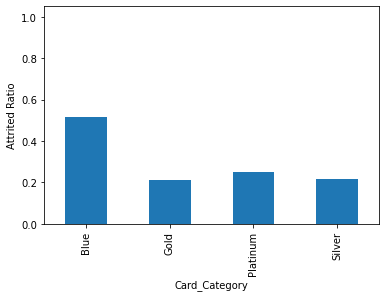

In [4]:
bank_df.describe()

# Contacts_Count_12_mon
by_contact_df = bank_df.groupby('Contacts_Count_12_mon')['Attrition_Flag'].mean()
by_contact_df.plot(kind='bar', ylabel='Attrited Ratio')

# Months_Inactive_12_mon
by_inactive_df = bank_df.groupby('Months_Inactive_12_mon')['Attrition_Flag'].mean()
by_inactive_df.plot(kind='bar', ylabel='Attrited Ratio')

# Education level
by_edu_df = bank_df.groupby('Education_Level')['Attrition_Flag'].mean()
by_edu_df.plot(kind='bar', ylabel='Attrited Ratio')

# Marital_Status
by_marry_df = bank_df.groupby('Marital_Status')['Attrition_Flag'].mean()
by_marry_df.plot(kind='bar', ylabel='Attrited Ratio')

# Income_Category
by_income_df = bank_df.groupby('Income_Category')['Attrition_Flag'].mean()
by_income_df.plot(kind='bar', ylabel='Attrited Ratio')

# Gender
by_gender_df = bank_df.groupby('Gender')['Attrition_Flag'].mean()
by_gender_df.plot(kind='bar', ylabel='Attrited Ratio')

# Card_Category
by_card_df = bank_df.groupby('Card_Category')['Attrition_Flag'].mean()
by_card_df.plot(kind='bar', ylabel='Attrited Ratio')

# Credit Limit
print("Avg attrition of customers with minimun credit limit: ", 
      bank_df[bank_df['Credit_Limit']==bank_df['Credit_Limit'].min()]['Attrition_Flag'].mean())
print("Avg attrition of customers with more credit limit: ", 
      bank_df[bank_df['Credit_Limit']!=bank_df['Credit_Limit'].min()]['Attrition_Flag'].mean())

# Total_Revolving_Bal
print("Avg attrition of customers with 0 revolving balance: ", 
      bank_df[bank_df['Total_Revolving_Bal']==0]['Attrition_Flag'].mean())
print("Avg attrition of customers with more revolving balance: ", 
      bank_df[bank_df['Total_Revolving_Bal']!=0]['Attrition_Flag'].mean())

# Utilization_Ratio
print("Avg attrition of customers with 0 utilization ratio: ", 
      bank_df[bank_df['Avg_Utilization_Ratio']==bank_df['Avg_Utilization_Ratio'].min()]['Attrition_Flag'].mean())
print("Avg attrition of customers with more utilization ratio: ", 
      bank_df[bank_df['Avg_Utilization_Ratio']!=bank_df['Avg_Utilization_Ratio'].min()]['Attrition_Flag'].mean())

In [3]:
# Feature Engineering

# KNN for Unknown
tmp_bank_df = bank_df.copy()

le_ls = []
for col in ['Education_Level', 'Marital_Status', 'Income_Category']:
    le = LabelEncoder()
    tmp_bank_df[col] = le.fit_transform(tmp_bank_df[col])
    keys = le.classes_
    values = le.transform(le.classes_)
    dictionary = dict(zip(keys, values))
    le_ls.append(le)
    print(dictionary)
    tmp_bank_df.loc[tmp_bank_df[col]==dictionary['Unknown'], col] = np.nan

tmp_bank_df = pd.get_dummies(tmp_bank_df)

# Use KNN to fill for each column
for col in ['Marital_Status', 'Income_Category', 'Education_Level']:
    imputer = KNNImputer(n_neighbors = 5)
    fill_tmp_bank_df = pd.DataFrame(imputer.fit_transform(tmp_bank_df.iloc[:,1:]), 
                                    index=tmp_bank_df.index, columns=tmp_bank_df.columns[1:])
    tmp_bank_df[col] = fill_tmp_bank_df[col]

i = 0
for col in ['Education_Level', 'Marital_Status', 'Income_Category']:
    tmp_bank_df[col] = le_ls[i].inverse_transform(round(tmp_bank_df[col], 0).astype(int))
    i += 1
    
bank_df = tmp_bank_df

{'College': 0, 'Doctorate': 1, 'Graduate': 2, 'High School': 3, 'Post-Graduate': 4, 'Uneducated': 5, 'Unknown': 6}
{'Divorced': 0, 'Married': 1, 'Single': 2, 'Unknown': 3}
{'$120K +': 0, '$40K - $60K': 1, '$60K - $80K': 2, '$80K - $120K': 3, 'Less than $40K': 4, 'Unknown': 5}


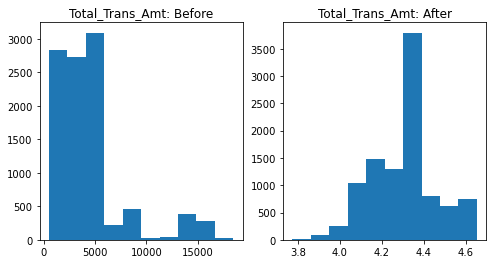

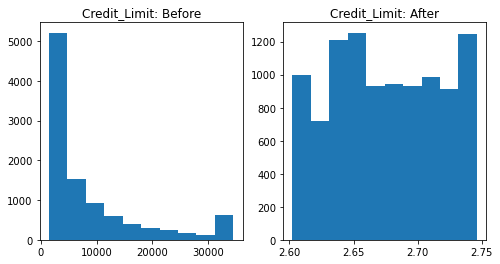

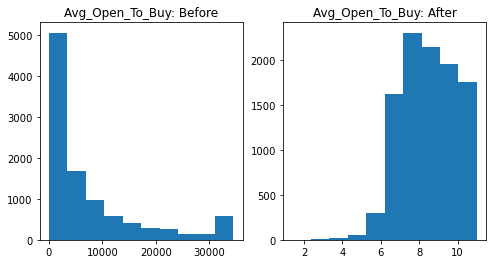

In [4]:
# One-hot encoding
bank_df = pd.get_dummies(bank_df)

# Add new features
# Avg trans amt 
bank_df['Avg_Trans_Amt'] = bank_df['Total_Trans_Amt']/bank_df['Total_Trans_Ct']
# Creat new categorical feature based on whether credit limit equals min credit limit
bank_df.loc[bank_df['Credit_Limit']==bank_df['Credit_Limit'].min(), 'Min_Credit_Limit'] = 1
bank_df['Min_Credit_Limit'].fillna(0, inplace=True)
# Creat new categorical feature based on whether total balance equals 0
bank_df.loc[bank_df['Total_Revolving_Bal']==0, '0_Total_Revolving_Bal'] = 1
bank_df['0_Total_Revolving_Bal'].fillna(0, inplace=True)
# Creat new categorical feature based on whether total balance equals 0
bank_df.loc[bank_df['Avg_Utilization_Ratio']==0, '0_Avg_Utilization_Ratio'] = 1
bank_df['0_Avg_Utilization_Ratio'].fillna(0, inplace=True)
# Determine amount decrease or increase based on Amt_Chng_Q4_Q1
bank_df.loc[bank_df['Total_Amt_Chng_Q4_Q1']<bank_df['Total_Amt_Chng_Q4_Q1'].median(), 'Amt_Q4_Q1_Dec'] = 1
bank_df['Amt_Q4_Q1_Dec'].fillna(0, inplace=True)
# Determine count decrease or increase based on Ct_Chng_Q4_Q1
bank_df.loc[bank_df['Total_Ct_Chng_Q4_Q1']<bank_df['Total_Ct_Chng_Q4_Q1'].median(), 'Ct_Q4_Q1_Dec'] = 1
bank_df['Ct_Q4_Q1_Dec'].fillna(0, inplace=True)



# Transformation
skewed_col = ['Total_Trans_Amt', 'Credit_Limit', 'Avg_Open_To_Buy']
trans_bank_df = bank_df.copy()
for col in skewed_col:
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.hist(bank_df[col])
    plt.title(f"{col}: Before")
    trans_bank_df[col] = boxcox1p(bank_df[col], boxcox_normmax(bank_df[col] + 1))
    plt.subplot(1, 2, 2)
    plt.hist(trans_bank_df[col])
    plt.title(f"{col}: After")

# Standardize
std = StandardScaler()
std_df = pd.DataFrame(std.fit_transform(trans_bank_df.iloc[:,1:]), 
                      index = trans_bank_df.index, 
                      columns = trans_bank_df.columns[1:])
std_bank_df = pd.concat([trans_bank_df.iloc[:,0], std_df], axis=1)

In [5]:
# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [9]:
# SVM
X_train, X_test, y_train, y_test = train_test_split(std_bank_df.iloc[:,1:], std_bank_df.iloc[:,0], test_size=0.25, random_state=42)
svm_clf = svm.SVC()

svm_param = {'C': [0.1, 1, 10, 100], 
             'gamma': ['scale', 'auto'],
             'kernel': ['rbf', 'poly', 'sigmoid'],
             'probability':[True],
             'class_weight':['balanced', 'none']}
svm_grid = GridSearchCV(svm_clf, svm_param, n_jobs=-1, cv=5, verbose=1)
svm_grid.fit(X_train, y_train)
print("Best param: ", svm_grid.best_params_)
svm_pred = svm_grid.predict(X_test)
svm_pred_prob = svm_grid.predict_proba(X_test)[:,1]
svm_pred_df = pd.DataFrame({"pred":svm_pred, "prob":svm_pred_prob, "actual":y_test})
# mannually adjust pred based on prob
thresh = np.quantile(svm_pred_prob, (1-y_train.mean()))
svm_pred_df['pred'] = (svm_pred_df['prob']>thresh).astype(int)
svm_pred_df

X, y = std_bank_df.iloc[:,1:], std_bank_df.iloc[:,0]

title = "Learning Curves for SVM" 
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)


estimator = svm.SVC(C=10, 
                    class_weight='balanced', 
                    gamma='scale', 
                    kernel='rbf', 
                    probability=True)
plot_learning_curve(
    estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

print( "accuracy:"+str(np.average(cross_val_score(svm_clf, X_test, y_test, scoring=  'accuracy'))))
print(       "f1:"+str(np.average(cross_val_score(svm_clf, X_test, y_test, scoring=  'f1'))))
print("precision:"+str(np.average(cross_val_score(svm_clf, X_test, y_test, scoring=  'precision'))))
print(   "recall:"+str(np.average(cross_val_score(svm_clf, X_test, y_test, scoring=  'recall'))))


Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Best param:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 100, 'max_features': 0.25, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


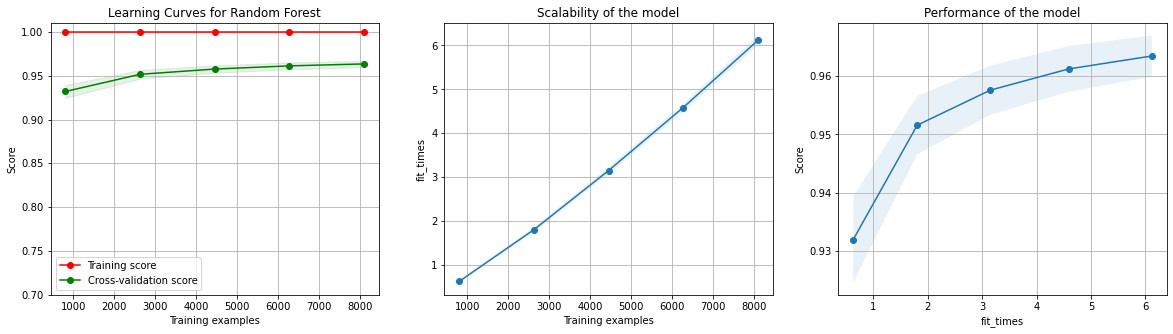

accuracy:0.9399716225803182
f1:0.8049584937954641
precision:0.8810008391542272
recall:0.7375788869764774


In [8]:
rf = RandomForestClassifier()
n_estimators = [100, 200, 300]
max_features = [0.5, 0.25, 'log2', 'sqrt']
max_depth = [100, 200, 'none']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'none']
rf_param = {'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap,
            'class_weight': class_weight}
rf_grid = GridSearchCV(rf, rf_param, n_jobs=-1, cv=5, verbose=1)
rf_grid.fit(X_train, y_train)
print("Best param: ", rf_grid.best_params_)
rf_pred = rf_grid.predict(X_test)
rf_pred_prob = rf_grid.predict_proba(X_test)[:,1]
rf_pred_df = pd.DataFrame({"pred":rf_pred, "prob":rf_pred_prob, "actual":y_test})

# mannually adjust pred based on prob
thresh = np.quantile(rf_pred_prob, (1-y_train.mean()))
rf_pred_df['pred'] = (rf_pred_df['prob']>thresh).astype(int)

rf_pred_df

X, y = std_bank_df.iloc[:,1:], std_bank_df.iloc[:,0]

title = "Learning Curves for Random Forest"

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(bootstrap=False, 
                                   class_weight='balanced', 
                                   max_depth=200, 
                                   max_features=0.25, 
                                   min_samples_leaf=1,
                                   min_samples_split=2,
                                   n_estimators=300)
plot_learning_curve(
    estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

print( "accuracy:"+str(np.average(cross_val_score(estimator, X_test, y_test, scoring=  'accuracy'))))
print(       "f1:"+str(np.average(cross_val_score(estimator, X_test, y_test, scoring=  'f1'))))
print("precision:"+str(np.average(cross_val_score(estimator, X_test, y_test, scoring=  'precision'))))
print(   "recall:"+str(np.average(cross_val_score(estimator, X_test, y_test, scoring=  'recall'))))
